# Finetune Borzoi for scATAC peaks

In this tutorial, we'll show how to finetune the Borzoi model to do peak regression on scATAC data.

In [1]:
import os
import zipfile
import tempfile

import numpy as np
import pandas as pd
import anndata as ad
import tensorflow as tf
import keras
import wandb
import crested

2025-02-14 13:01:03.191353: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 13:01:11.480580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 13:02:30.353412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
resources_dir = "/staging/leuven/res_00001/genomes/mus_musculus/mm10_ucsc/fasta/"
genome_file = os.path.join(resources_dir, "mm10.fa")
chromsizes_file = os.path.join(resources_dir, "mm10.chrom.sizes")
folds_file = "consensus_peaks_borsplit.bed"

In [3]:
genome = crested.Genome(genome_file, chromsizes_file)
crested.register_genome(genome)

2025-02-14T13:07:13.655587+0100 INFO Genome mm10 registered.


## Read in scATAC data

We'll use the same dataset as used in the default tutorial, the mouse BICCN dataset, derived from the brain cortex.

In [4]:
bigwigs_folder, regions_file = crested.get_dataset("mouse_cortex_bigwig_cut_sites")

In [5]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000, 
    target="count",
)
adata

2025-02-14T13:08:31.442981+0100 INFO Extracting values from 19 bigWig files...


AnnData object with n_obs × n_vars = 19 × 546993
    obs: 'file_path'
    var: 'chr', 'start', 'end'

### Add train/val/test split

Generally, for finetuning, it's recommended to use the train/test split from the original model, like Borzoi here.  
This can be derived by intersecting your consensus peaks with `sequences_mouse.bed` from the Borzoi repository, like with BEDTools:

```
regions_file="consensus_peaks_biccn.bed" # regions_file from crested.get_dataset()
folds_file="sequences_mouse.bed" # From Borzoi repo
output_file="consensus_peaks_borsplit.bed"

grep fold3 ${folds_file} | sort -k1,1 -k2,2n | bedtools merge -i stdin -d 10 | bedtools intersect -a ${regions_file} -b stdin -wa -f 0.5 | sed $'s/$/\t'test/ > ${output_file}
grep fold4 ${folds_file} | sort -k1,1 -k2,2n | bedtools merge -i stdin -d 10 | bedtools intersect -a ${regions_file} -b stdin -wa -f 0.5 | sed $'s/$/\t'val/ >> ${output_file}
for i in 0 1 2 5 6 7; do
    grep fold${i} ${folds_file} | sort -k1,1 -k2,2n | bedtools merge -i stdin -d 10 | bedtools intersect -a ${regions_file} -b stdin -wa -f 0.5 | sed $'s/$/\t'train/ >> ${output_file}
done

```


In [6]:
folds = pd.read_csv(folds_file, sep = '\t', names = ['name', 'split'], usecols = [3, 4]).set_index("name")
print(f"% of regions found in folds file: {adata.var_names.isin(folds.index).sum()/adata.n_vars*100:.3f}%")

% of regions found in folds file: 99.425%


In [7]:
# Drop regions not in any folds
print(f"Dropping {(~adata.var_names.isin(folds.index)).sum()} regions because they are not in any fold.")
adata = adata[:, adata.var_names.isin(folds.index)].copy()

# Add fold data to var
adata.var = adata.var.join(folds)

# Check result
adata.var['split'].value_counts(dropna=False)

Dropping 3146 regions because they are not in any fold.


split
train    412229
val       72744
test      58874
Name: count, dtype: int64

Alternatively, you could use the default train/test split function set a chromosome-based or random split:

In [ ]:
# crested.pp.train_val_test_split(
#     adata, strategy="chr", val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"]
# )

## Preprocessing
For the preprocessing, we'll again follow the default steps, except for the adjusted input size.

### Region width

In this example, we'll use 2048bp inputs, to align with the 2114bp input size of the standard CNN peak regression models while staying within a multiple of 128. Therefore, we'll need to resize our regions:

In [8]:
crested.pp.change_regions_width(
    adata,
    2048,
)

### Peak normalization

We can normalize our peak values based on the variability of the top peak heights per cell type using the {func}`crested.pp.normalize_peaks` function.  

This function applies a normalization scalar to each cell type, obtained by comparing per cell type the distribution of peak heights for the maximally accessible regions which are not specific to any cell type.

In [9]:
crested.pp.normalize_peaks(
    adata, top_k_percent=0.03
)  # The top_k_percent parameters can be tuned based on potential bias towards cell types. If some weights are overcompensating too much, consider increasing the top_k_percent. Default is 0.01

2025-02-14T13:09:21.187809+0100 INFO Filtering on top k Gini scores...
2025-02-14T13:09:28.069781+0100 INFO Added normalization weights to adata.obsm['weights']...


,chr,start,end,split
region,,,,
chr9:76566142-76568190,chr9,76566142,76568190,train
chr5:98328510-98330558,chr5,98328510,98330558,train
chr5:98347819-98349867,chr5,98347819,98349867,train
chr13:34635167-34637215,chr13,34635167,34637215,train
chr13:34642109-34644157,chr13,34642109,34644157,train
...,...,...,...,...
chr13:34344270-34346318,chr13,34344270,34346318,train
chr5:98166140-98168188,chr5,98166140,98168188,train
chr5:98166667-98168715,chr5,98166667,98168715,train


We can visualize the normalization factor for each cell type using the {func}`crested.pl.bar.normalization_weights` function to inspect which cell type peaks were up/down weighted.

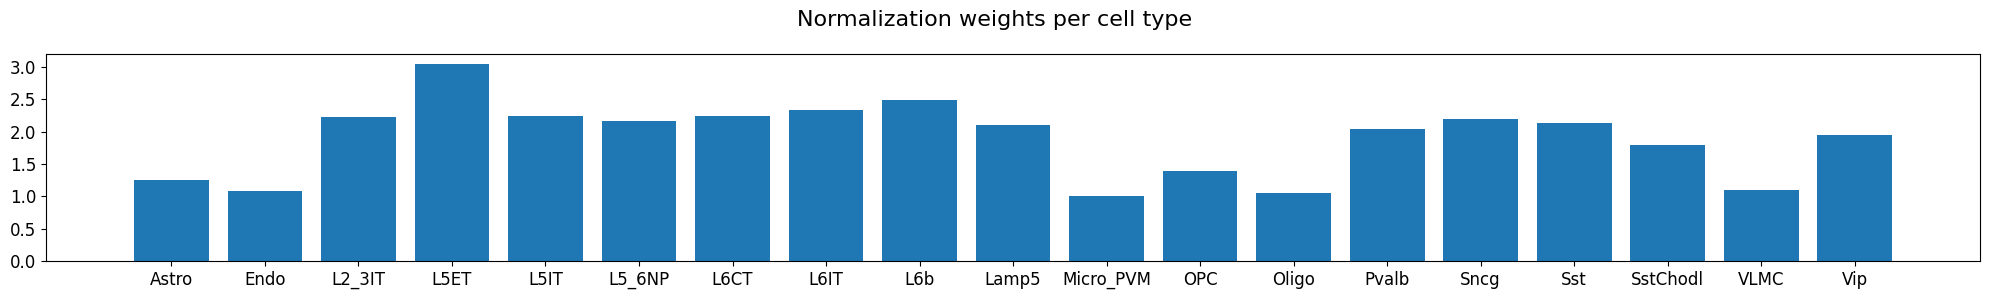

In [10]:
%matplotlib inline
crested.pl.bar.normalization_weights(adata, title="Normalization weights per cell type")

## Load in model

We load in the Borzoi model's weights in its architecture, with one change - the input length. All of Borzoi's layers are width-independent, so the length can be set to any value divisible by the internal bin size (128bp).  
`target_length` is set to the total number of output bins (64 bins of 32bp makes 2048bp output), since no cropping is needed when predicting local features.  
`num_classes` is set to the original size simply so that there are no weight shape mismatches when loading the initial weights; the head created based on `num_classes` will be replaced by a new head for the number of cell types we'd like to predict below.

In [11]:
# Create default Borzoi architecture, with shrunk input size and target_length
base_model_architecture = crested.tl.zoo.borzoi(seq_len=2048, target_length = 2048//32, num_classes = 2608)

2025-02-14 13:09:33.445930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78783 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:26:00.0, compute capability: 9.0


To load in the weights, we can't directly load the model from the `.keras` file, since that fixes the input length at the previously set value (524288bp). However, we can extract the `model.weights.h5` file containing only the weights and use that. 

In [12]:
# Load pretrained Borzoi weights
model_file, _ = crested.get_model("Borzoi_mouse_rep0")
# Put weights into base architecture
with zipfile.ZipFile(model_file) as model_archive, tempfile.TemporaryDirectory() as tmpdir:
    model_weights_path = model_archive.extract('model.weights.h5', tmpdir)
    base_model_architecture.load_weights(model_weights_path)

Now that we have the base model with the adjusted input shape, we need to adjust the final layers to return a value for each cell type per region, instead of per-bin values. Therefore, we drop the final head, add a flatten layer after the model's final embedding, and add a new head predicting `adata.n_obs` values. 

In [13]:
# Replace track head by flatten+dense to predict single vector of scalars per region
## Get last layer before head
current = base_model_architecture.get_layer("final_conv_activation").output
## Flatten and add new layer
current = keras.layers.Flatten()(current)
current = keras.layers.Dense(
    adata.n_obs, activation='softplus', name="dense_out"
)(current)

# Turn into model
model_architecture = keras.Model(inputs = base_model_architecture.inputs, outputs = current, name = 'Borzoi_scalar')
print(model_architecture.summary())

Model: "Borzoi_scalar"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 2048, 4)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv1D)  │ (None, 2048, 512) │     31,232 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 1024, 512) │          0 │ stem_conv[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_batch… │ (None, 1024, 512) │      2,048 │ stem_pool[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_activ… │ (None, 1024, 512) │          0 │ tower_conv_1_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_conv   │ (None, 1024, 608) │  1,557,088 │ tower_conv_1_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_pool   │ (None, 512, 608)  │          0 │ tower_conv_1_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_batch… │ (None, 512, 608)  │      2,432 │ tower_conv_1_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_activ… │ (None, 512, 608)  │          0 │ tower_conv_2_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_conv   │ (None, 512, 736)  │  2,238,176 │ tower_conv_2_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_pool   │ (None, 256, 736)  │          0 │ tower_conv_2_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_batch… │ (None, 256, 736)  │      2,944 │ tower_conv_2_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_activ… │ (None, 256, 736)  │          0 │ tower_conv_3_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_conv   │ (None, 256, 896)  │  3,298,176 │ tower_conv_3_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_pool   │ (None, 128, 896)  │          0 │ tower_conv_3_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_batch… │ (None, 128, 896)  │      3,584 │ tower_conv_3_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_activ… │ (None, 128, 896)  │          0 │ tower_conv_4_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 170,213,747 (649.31 MB)

 Trainable params: 170,188,723 (649.22 MB)

 Non-trainable params: 25,024 (97.75 KB)

None


## Model Training
### Parameters

The DataModule and TaskConfig let you set standard training parameters, like batch size and learning rate.  
We use the same parameters as with peak regression in the default tutorial, except for a lower learning rate to match the fact that we are starting from a pre-trained model.

In [14]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome=genome,
    batch_size=32,  # lower this if you encounter OOM errors
    max_stochastic_shift=3,  # optional augmentation
    always_reverse_complement=True,  # default True. Will double the effective size of the training dataset.
)

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss = crested.tl.losses.CosineMSELogLoss(max_weight=100, multiplier=1)
metrics = [
    keras.metrics.MeanAbsoluteError(),
    keras.metrics.MeanSquaredError(),
    keras.metrics.CosineSimilarity(axis=1),
    crested.tl.metrics.PearsonCorrelation(),
    crested.tl.metrics.ConcordanceCorrelationCoefficient(),
    crested.tl.metrics.PearsonCorrelationLog(),
    crested.tl.metrics.ZeroPenaltyMetric(),
]

config = crested.tl.TaskConfig(optimizer, loss, metrics)
print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x1511019ba0d0>, loss=<crested.tl.losses._cosinemse_log.CosineMSELogLoss object at 0x1511019bf990>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


### Finetune on full peak set

By default: 
1. The model will continue training until the validation loss stops decreasing for 10 epochs with a maximum of 100 epochs.  
2. Every best model is saved based on the validation loss.
3. The learning rate reduces by a factor of 0.25 if the validation loss stops decreasing for 5 epochs.

In [23]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=config,
    project_name="biccn_borzoi_atac",
    run_name="testrun",
    logger="wandb", 
)

In [ ]:
# train the model
trainer.fit(epochs=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cas-blaauw. Use `wandb login --relogin` to force relogin


Model: "Borzoi_scalar"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 2048, 4)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv1D)  │ (None, 2048, 512) │     31,232 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 1024, 512) │          0 │ stem_conv[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_batch… │ (None, 1024, 512) │      2,048 │ stem_pool[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_activ… │ (None, 1024, 512) │          0 │ tower_conv_1_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_conv   │ (None, 1024, 608) │  1,557,088 │ tower_conv_1_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_pool   │ (None, 512, 608)  │          0 │ tower_conv_1_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_batch… │ (None, 512, 608)  │      2,432 │ tower_conv_1_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_activ… │ (None, 512, 608)  │          0 │ tower_conv_2_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_conv   │ (None, 512, 736)  │  2,238,176 │ tower_conv_2_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_pool   │ (None, 256, 736)  │          0 │ tower_conv_2_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_batch… │ (None, 256, 736)  │      2,944 │ tower_conv_2_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_activ… │ (None, 256, 736)  │          0 │ tower_conv_3_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_conv   │ (None, 256, 896)  │  3,298,176 │ tower_conv_3_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_pool   │ (None, 128, 896)  │          0 │ tower_conv_3_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_batch… │ (None, 128, 896)  │      3,584 │ tower_conv_3_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_activ… │ (None, 128, 896)  │          0 │ tower_conv_4_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 170,213,747 (649.31 MB)

 Trainable params: 170,188,723 (649.22 MB)

 Non-trainable params: 25,024 (97.75 KB)

None
2025-02-13T16:17:01.947660+0100 INFO Loading sequences into memory...


100%|██████████| 412229/412229 [00:08<00:00, 50087.97it/s]


2025-02-13T16:17:10.887463+0100 INFO Loading sequences into memory...


100%|██████████| 72744/72744 [00:01<00:00, 64969.36it/s]


Epoch 1/10


I0000 00:00:1739459848.260829   58982 service.cc:145] XLA service 0x14ebd0002860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739459848.278096   58982 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-02-13 16:17:31.714326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-13 16:17:36.093618: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1739459885.396267   63454 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_273', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1739459885.438837   63458 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:17394

25764/25765 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - concordance_correlation_coefficient: 0.7620 - cosine_similarity: 0.8605 - loss: -0.5721 - mean_absolute_error: 2.5347 - mean_squared_error: 28.2751 - pearson_correlation: 0.8269 - pearson_correlation_log: 0.6319 - zero_penalty_metric: 135.2008

I0000 00:00:1739460737.958359   65318 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_289', 20 bytes spill stores, 20 bytes spill loads

2025-02-13 16:32:21.899626: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 167.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-13 16:32:21.899676: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 167.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-13 16:32:22.964727: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 74.27GiB with freed_by_count=0. The c

25765/25765 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - concordance_correlation_coefficient: 0.7620 - cosine_similarity: 0.8605 - loss: -0.5721 - mean_absolute_error: 2.5347 - mean_squared_error: 28.2748 - pearson_correlation: 0.8269 - pearson_correlation_log: 0.6319 - zero_penalty_metric: 135.2008

I0000 00:00:1739460764.746541   58980 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1739460793.796110   65598 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_65', 4 bytes spill stores, 4 bytes spill loads



25765/25765 ━━━━━━━━━━━━━━━━━━━━ 969s 34ms/step - concordance_correlation_coefficient: 0.7620 - cosine_similarity: 0.8605 - loss: -0.5721 - mean_absolute_error: 2.5347 - mean_squared_error: 28.2745 - pearson_correlation: 0.8269 - pearson_correlation_log: 0.6319 - zero_penalty_metric: 135.2007 - val_concordance_correlation_coefficient: 0.8757 - val_cosine_similarity: 0.8763 - val_loss: -0.6293 - val_mean_absolute_error: 2.1752 - val_mean_squared_error: 18.0886 - val_pearson_correlation: 0.8776 - val_pearson_correlation_log: 0.6524 - val_zero_penalty_metric: 138.8675 - learning_rate: 1.0000e-05
Epoch 2/10
25765/25765 ━━━━━━━━━━━━━━━━━━━━ 832s 32ms/step - concordance_correlation_coefficient: 0.8893 - cosine_similarity: 0.8847 - loss: -0.6589 - mean_absolute_error: 2.0946 - mean_squared_error: 15.5250 - pearson_correlation: 0.9042 - pearson_correlation_log: 0.6722 - zero_penalty_metric: 133.3652 - val_concordance_correlation_coefficient: 0.8768 - val_cosine_similarity: 0.8804 - val_loss: -

### Further finetuning on specific regions

We found that finetuning on the full peak set, then on the filtered peak set improved performance over training only on either set. Therefore, we'll filter the peaks to keep only cell type-specific peaks and further finetune the model.

In [16]:
crested.pp.filter_regions_on_specificity(
    adata, gini_std_threshold=1.0
)

2025-02-14T13:09:51.664914+0100 INFO After specificity filtering, kept 91002 out of 543847 regions.


In [17]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome=genome,
    batch_size=32,  # lower this if you encounter OOM errors
    max_stochastic_shift=3,  # optional augmentation
    always_reverse_complement=True,  # default True. Will double the effective size of the training dataset.
)

In [18]:
optimizer = keras.optimizers.Adam(learning_rate=5e-5)
loss = crested.tl.losses.CosineMSELogLoss(max_weight=100, multiplier=1)
metrics = [
    keras.metrics.MeanAbsoluteError(),
    keras.metrics.MeanSquaredError(),
    keras.metrics.CosineSimilarity(axis=1),
    crested.tl.metrics.PearsonCorrelation(),
    crested.tl.metrics.ConcordanceCorrelationCoefficient(),
    crested.tl.metrics.PearsonCorrelationLog(),
    crested.tl.metrics.ZeroPenaltyMetric(),
]

config = crested.tl.TaskConfig(optimizer, loss, metrics)
print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x151101c6d890>, loss=<crested.tl.losses._cosinemse_log.CosineMSELogLoss object at 0x151101c6e010>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


In [19]:
model_architecture = keras.models.load_model(
    "biccn_borzoi_atac/testrun/checkpoints/03.keras", compile=False 
)

In [20]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=config,
    project_name="biccn_borzoi_atac",
    run_name="testrun_ft",
    logger="wandb", 
)

In [21]:
# train the model
trainer.fit(epochs=5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cas-blaauw. Use `wandb login --relogin` to force relogin


Model: "Borzoi_scalar"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 2048, 4)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv1D)  │ (None, 2048, 512) │     31,232 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 1024, 512) │          0 │ stem_conv[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_batch… │ (None, 1024, 512) │      2,048 │ stem_pool[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_activ… │ (None, 1024, 512) │          0 │ tower_conv_1_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_conv   │ (None, 1024, 608) │  1,557,088 │ tower_conv_1_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_pool   │ (None, 512, 608)  │          0 │ tower_conv_1_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_batch… │ (None, 512, 608)  │      2,432 │ tower_conv_1_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_activ… │ (None, 512, 608)  │          0 │ tower_conv_2_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_conv   │ (None, 512, 736)  │  2,238,176 │ tower_conv_2_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_pool   │ (None, 256, 736)  │          0 │ tower_conv_2_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_batch… │ (None, 256, 736)  │      2,944 │ tower_conv_2_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_activ… │ (None, 256, 736)  │          0 │ tower_conv_3_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_conv   │ (None, 256, 896)  │  3,298,176 │ tower_conv_3_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_pool   │ (None, 128, 896)  │          0 │ tower_conv_3_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_batch… │ (None, 128, 896)  │      3,584 │ tower_conv_3_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_activ… │ (None, 128, 896)  │          0 │ tower_conv_4_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 170,213,747 (649.31 MB)

 Trainable params: 170,188,723 (649.22 MB)

 Non-trainable params: 25,024 (97.75 KB)

None
2025-02-14T13:10:34.604198+0100 INFO Loading sequences into memory...


100%|██████████| 67159/67159 [00:10<00:00, 6325.68it/s] 

2025-02-14T13:10:45.359384+0100 INFO Loading sequences into memory...



100%|██████████| 12962/12962 [00:01<00:00, 10852.57it/s]


Epoch 1/5


I0000 00:00:1739535063.237484  186568 service.cc:145] XLA service 0x150e3c0029e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739535063.259141  186568 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-02-14 13:11:07.159956: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-14 13:11:12.096181: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1739535102.795923  187049 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1739535103.128892  187050 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:173953

4197/4198 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - concordance_correlation_coefficient: 0.7256 - cosine_similarity: 0.8709 - loss: -0.6439 - mean_absolute_error: 1.6038 - mean_squared_error: 12.4116 - pearson_correlation: 0.7944 - pearson_correlation_log: 0.6196 - zero_penalty_metric: 320.1437

I0000 00:00:1739535288.172678  187648 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_289', 20 bytes spill stores, 20 bytes spill loads



4198/4198 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - concordance_correlation_coefficient: 0.7256 - cosine_similarity: 0.8709 - loss: -0.6439 - mean_absolute_error: 1.6038 - mean_squared_error: 12.4115 - pearson_correlation: 0.7944 - pearson_correlation_log: 0.6196 - zero_penalty_metric: 320.1441

I0000 00:00:1739535316.160650  186566 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_21', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1739535329.553017  187850 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_65', 4 bytes spill stores, 4 bytes spill loads



4198/4198 ━━━━━━━━━━━━━━━━━━━━ 288s 48ms/step - concordance_correlation_coefficient: 0.7256 - cosine_similarity: 0.8709 - loss: -0.6439 - mean_absolute_error: 1.6038 - mean_squared_error: 12.4114 - pearson_correlation: 0.7944 - pearson_correlation_log: 0.6196 - zero_penalty_metric: 320.1445 - val_concordance_correlation_coefficient: 0.6791 - val_cosine_similarity: 0.8512 - val_loss: -0.5814 - val_mean_absolute_error: 1.7332 - val_mean_squared_error: 14.4574 - val_pearson_correlation: 0.7423 - val_pearson_correlation_log: 0.6029 - val_zero_penalty_metric: 312.9736 - learning_rate: 5.0000e-05
Epoch 2/5
4198/4198 ━━━━━━━━━━━━━━━━━━━━ 139s 33ms/step - concordance_correlation_coefficient: 0.8034 - cosine_similarity: 0.9018 - loss: -0.7173 - mean_absolute_error: 1.4257 - mean_squared_error: 9.5457 - pearson_correlation: 0.8455 - pearson_correlation_log: 0.6463 - zero_penalty_metric: 318.2404 - val_concordance_correlation_coefficient: 0.7234 - val_cosine_similarity: 0.8542 - val_loss: -0.5963

batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/concordance_correlation_coefficient,▁▁▂▂▂▂▂▂▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
batch/cosine_similarity,▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
batch/loss,████████▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
batch/mean_absolute_error,████████▆▅▅▅▅▅▅▅▄▃▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
batch/mean_squared_error,███▇▇▇▇▇▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
batch/pearson_correlation,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
batch/pearson_correlation_log,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
batch/zero_penalty_metric,█▇▇▇████▇█▇▇▇▇▇▇▄▅▅▅▅▅▅▆▄▄▄▄▄▄▄▄▁▂▃▂▃▃▂▂
epoch/concordance_correlation_coefficient,▁▁▄▄▆▆▇▇██
epoch/cosine_similarity,▁▁▄▄▆▆▇▇██


## Evaluate model

We'll evaluate both the finetuned and further finetuned models.

In [22]:
model = keras.models.load_model(
    "biccn_borzoi_atac/testrun/checkpoints/03.keras"
)
model_ft = keras.models.load_model(
    "biccn_borzoi_atac/testrun_ft/checkpoints/02.keras"
)

In [23]:
# add predictions for model checkpoint to the adata
adata.layers["model"] = crested.tl.predict(adata, model_ft).T
adata.layers["model_ft"] = crested.tl.predict(adata, model).T

I0000 00:00:1739535969.434318  189087 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1739535969.988530  189089 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 4 bytes spill stores, 4 bytes spill loads



91002/91002 ━━━━━━━━━━━━━━━━━━━━ 318s 3ms/step
91002/91002 ━━━━━━━━━━━━━━━━━━━━ 318s 3ms/step


If you don't want to predict on the entire dataset, you can also predict on a given sequence or region by passing coordinates, a DNA sequence, or a one-hot encoded sequence to {meth}`~crested.tl.predict`.

Many of the plotting functions in the `crested.pl` module can be used to visualize these model predictions.  

In [24]:
# Define a dataframe with test set regions
test_df = adata.var[adata.var["split"] == "test"]
test_df

,chr,start,end,split
region,,,,
chr1:3094031-3096079,chr1,3094031,3096079,test
chr1:3094696-3096744,chr1,3094696,3096744,test
chr1:3112760-3114808,chr1,3112760,3114808,test
chr1:3133812-3135860,chr1,3133812,3135860,test
chr1:3164934-3166982,chr1,3164934,3166982,test
...,...,...,...,...
chrX:20751180-20753228,chrX,20751180,20753228,test
chrX:21388522-21390570,chrX,21388522,21390570,test
chrX:21392726-21394774,chrX,21392726,21394774,test


chr1:3899526-3901574
2025-02-14T13:37:41.075121+0100 INFO Plotting bar plots for region: chr1:3899526-3901574, models: ['model', 'model_ft']


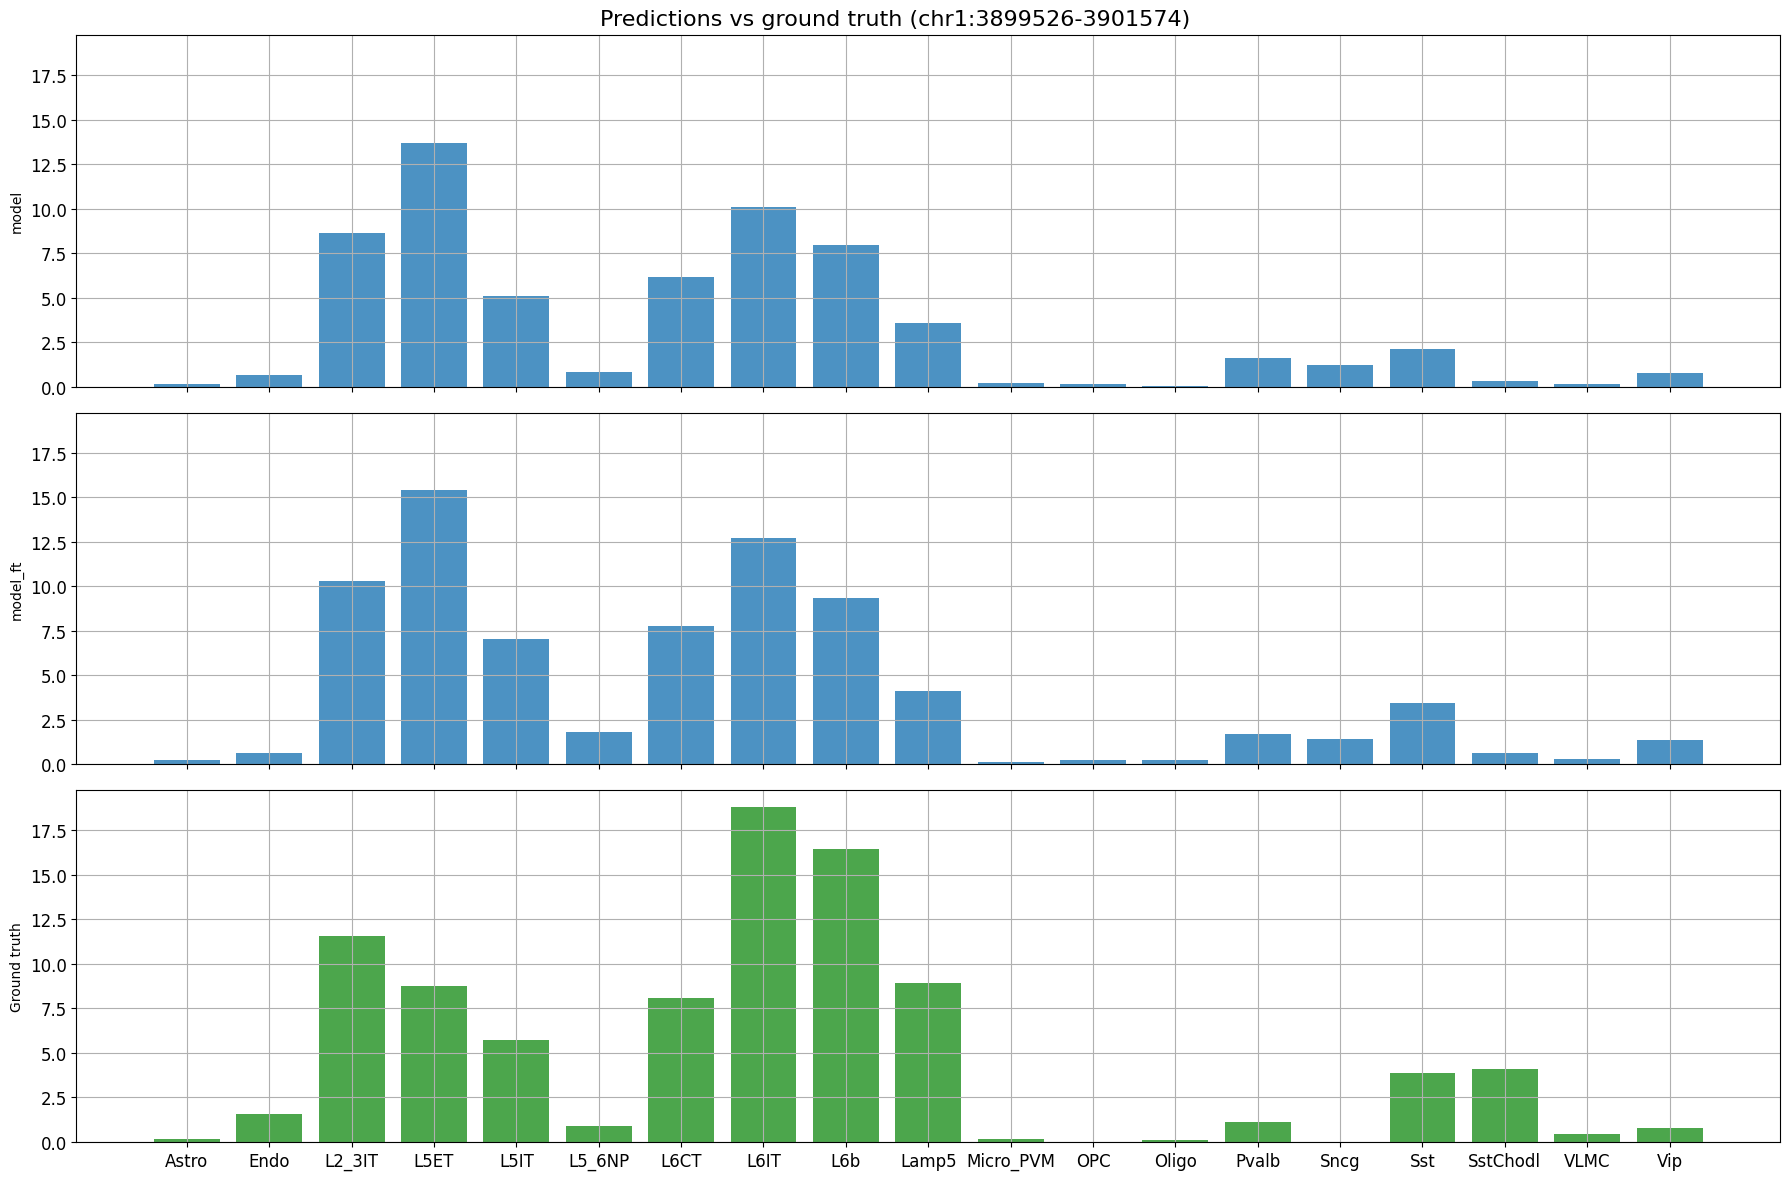

In [25]:
# plot predictions vs ground truth for a random region in the test set defined by index
%matplotlib inline
idx = 22
region = test_df.index[idx]
print(region)
crested.pl.bar.region_predictions(adata, region, title=f"Predictions vs ground truth ({region})")


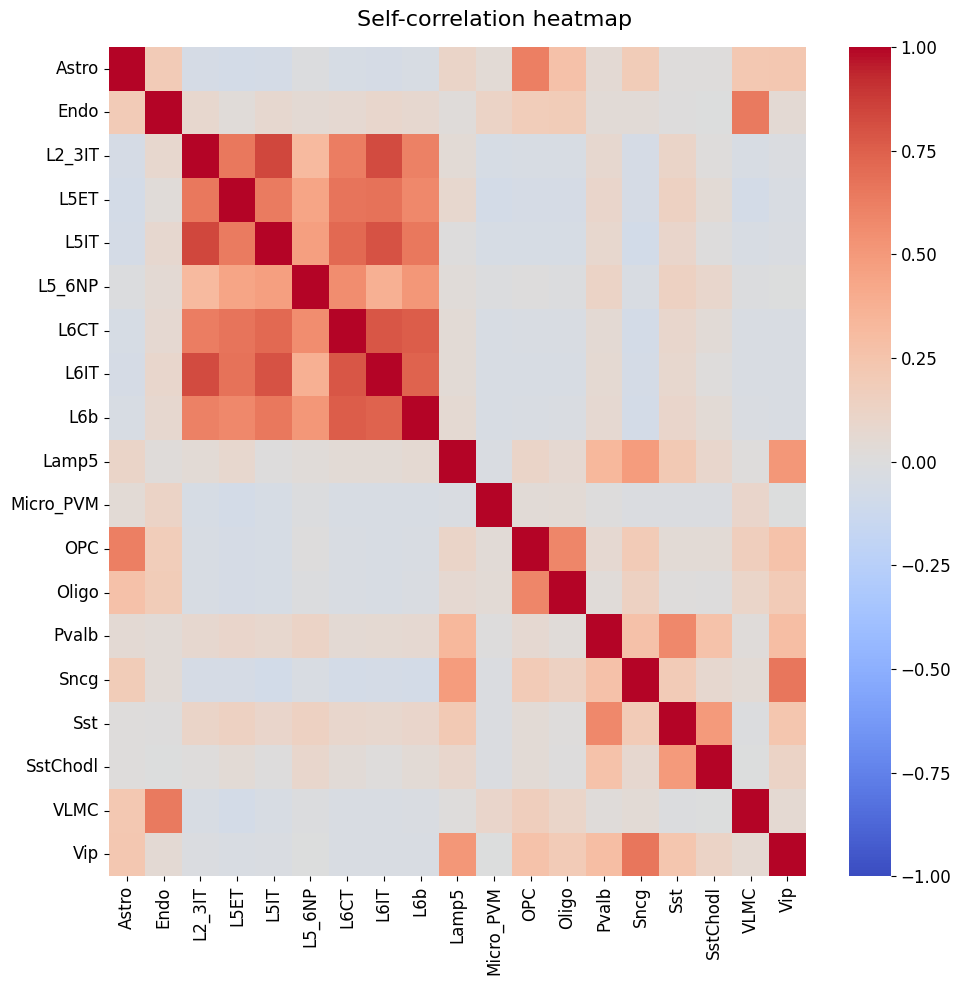

In [30]:
crested.pl.heatmap.correlations_self(
    adata, title="Self-correlation heatmap", x_label_rotation=90, width=10, height=10, vmin = -1, vmax = 1
)

2025-02-14T13:38:10.984708+0100 INFO Plotting heatmap correlations for split: test, models: ['model', 'model_ft']


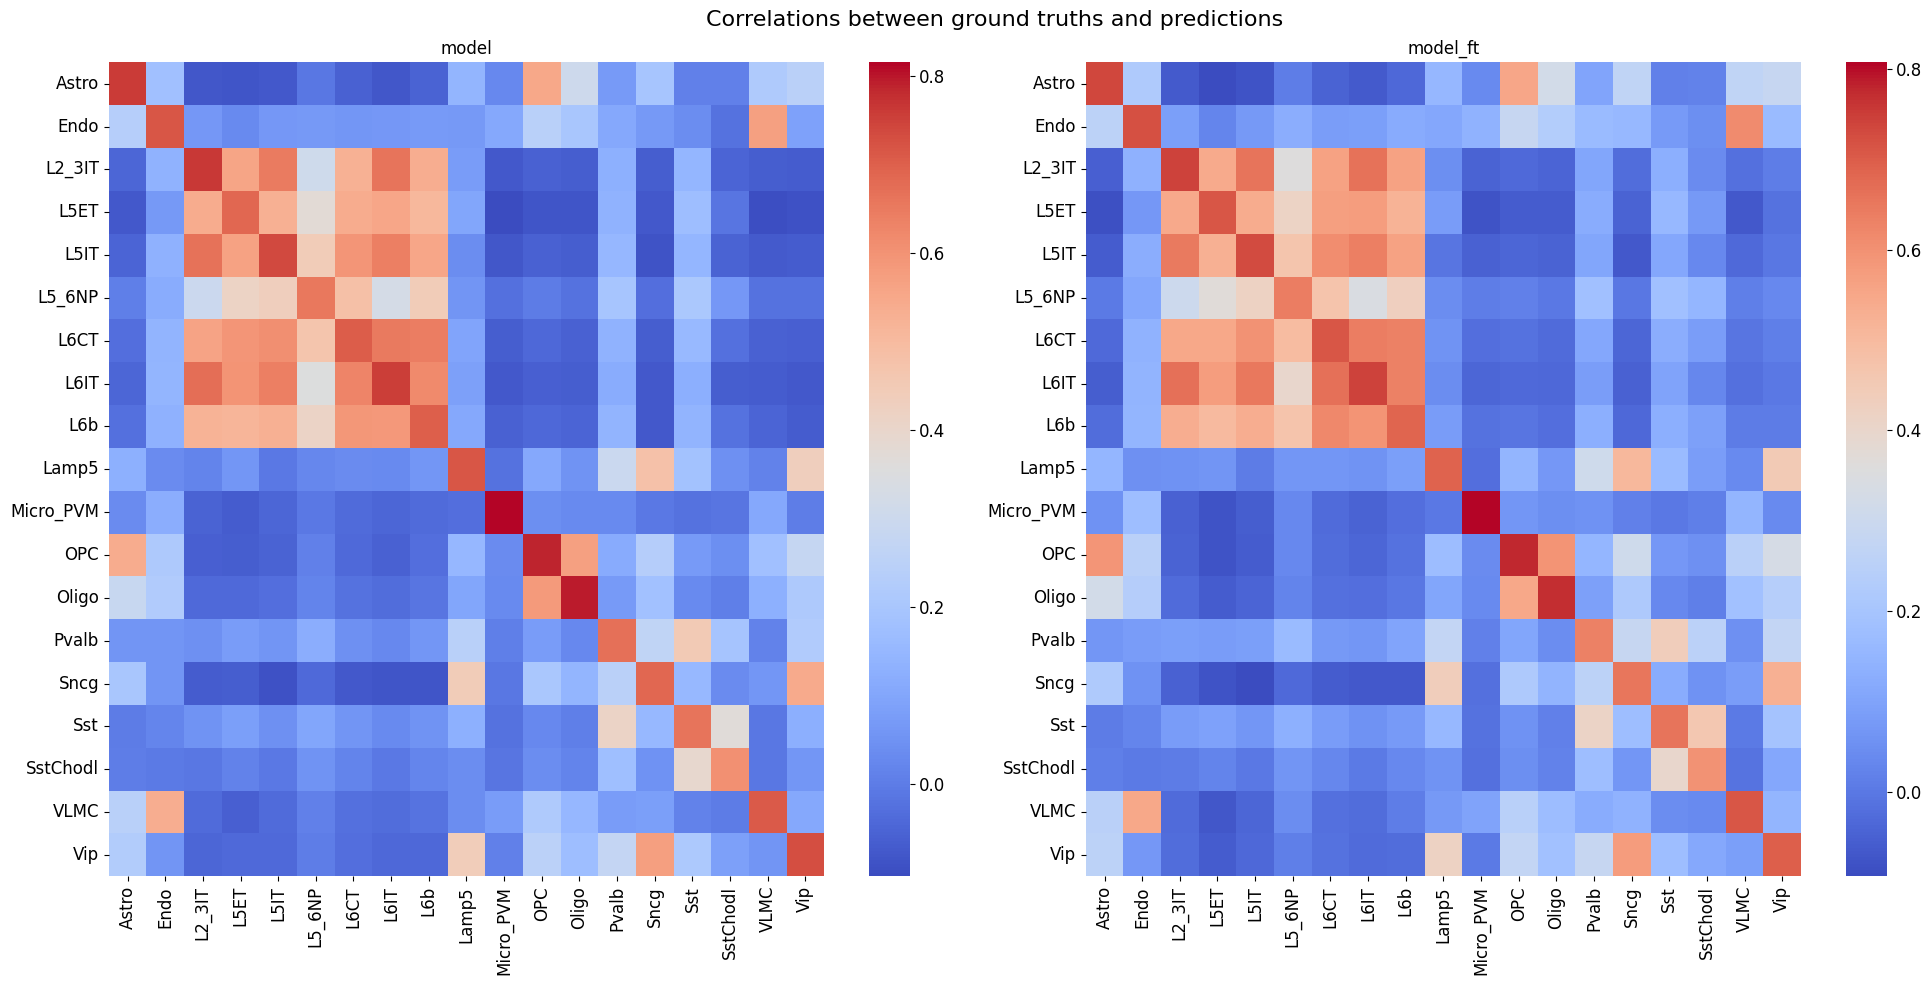

In [29]:
crested.pl.heatmap.correlations_predictions(
    adata,
    split="test",
    title="Correlations between ground truths and predictions",
    x_label_rotation=90,
    width=20,
    height=10,
    log_transform=False,
    # vmin = -1,
    # vmax = 1,
)

2025-02-14T13:39:20.714235+0100 INFO Plotting density scatter for all targets and predictions, models: ['model', 'model_ft'], split: test


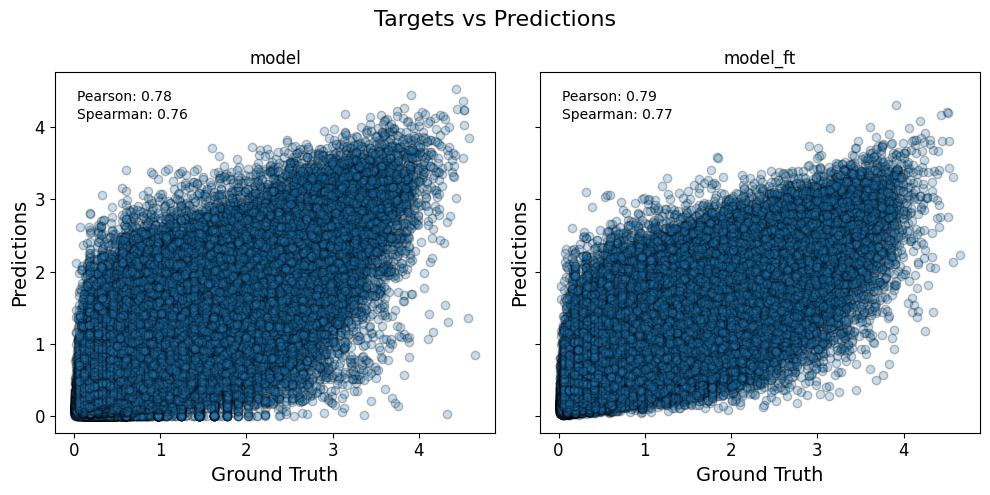

In [32]:
crested.pl.scatter.class_density(
    adata,
    split="test",
    log_transform=True,
    width=10,
    height=5,
)

Besides looking at prediction scores, we can also use these models to explain the features in the sequence that contributed to predicted accessibility in a certain cell type.  
Here, we'll look at three regions, expected to be active in microglia (`Micro_PVM`), Sst/Chodl GABAergic neurons (`SstChodl`), or in layer 6b glutamatergic neurons (`L6b`) respectively.

In [48]:
regions_of_interest = [
    "chr18:61107803-61109851",
    "chr13:92952218-92954266",
    "chr9:56036511-56038559",
]
classes_of_interest = ["Micro_PVM", "SstChodl", "L6b"]
class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    regions_of_interest,
    target_idx=class_idx,
    model=model_ft,
)

2025-02-14T13:57:00.326922+0100 INFO Calculating contribution scores for 3 class(es) and 3 region(s).


Model: 100%|██████████| 1/1 [00:53<00:00, 53.69s/it]


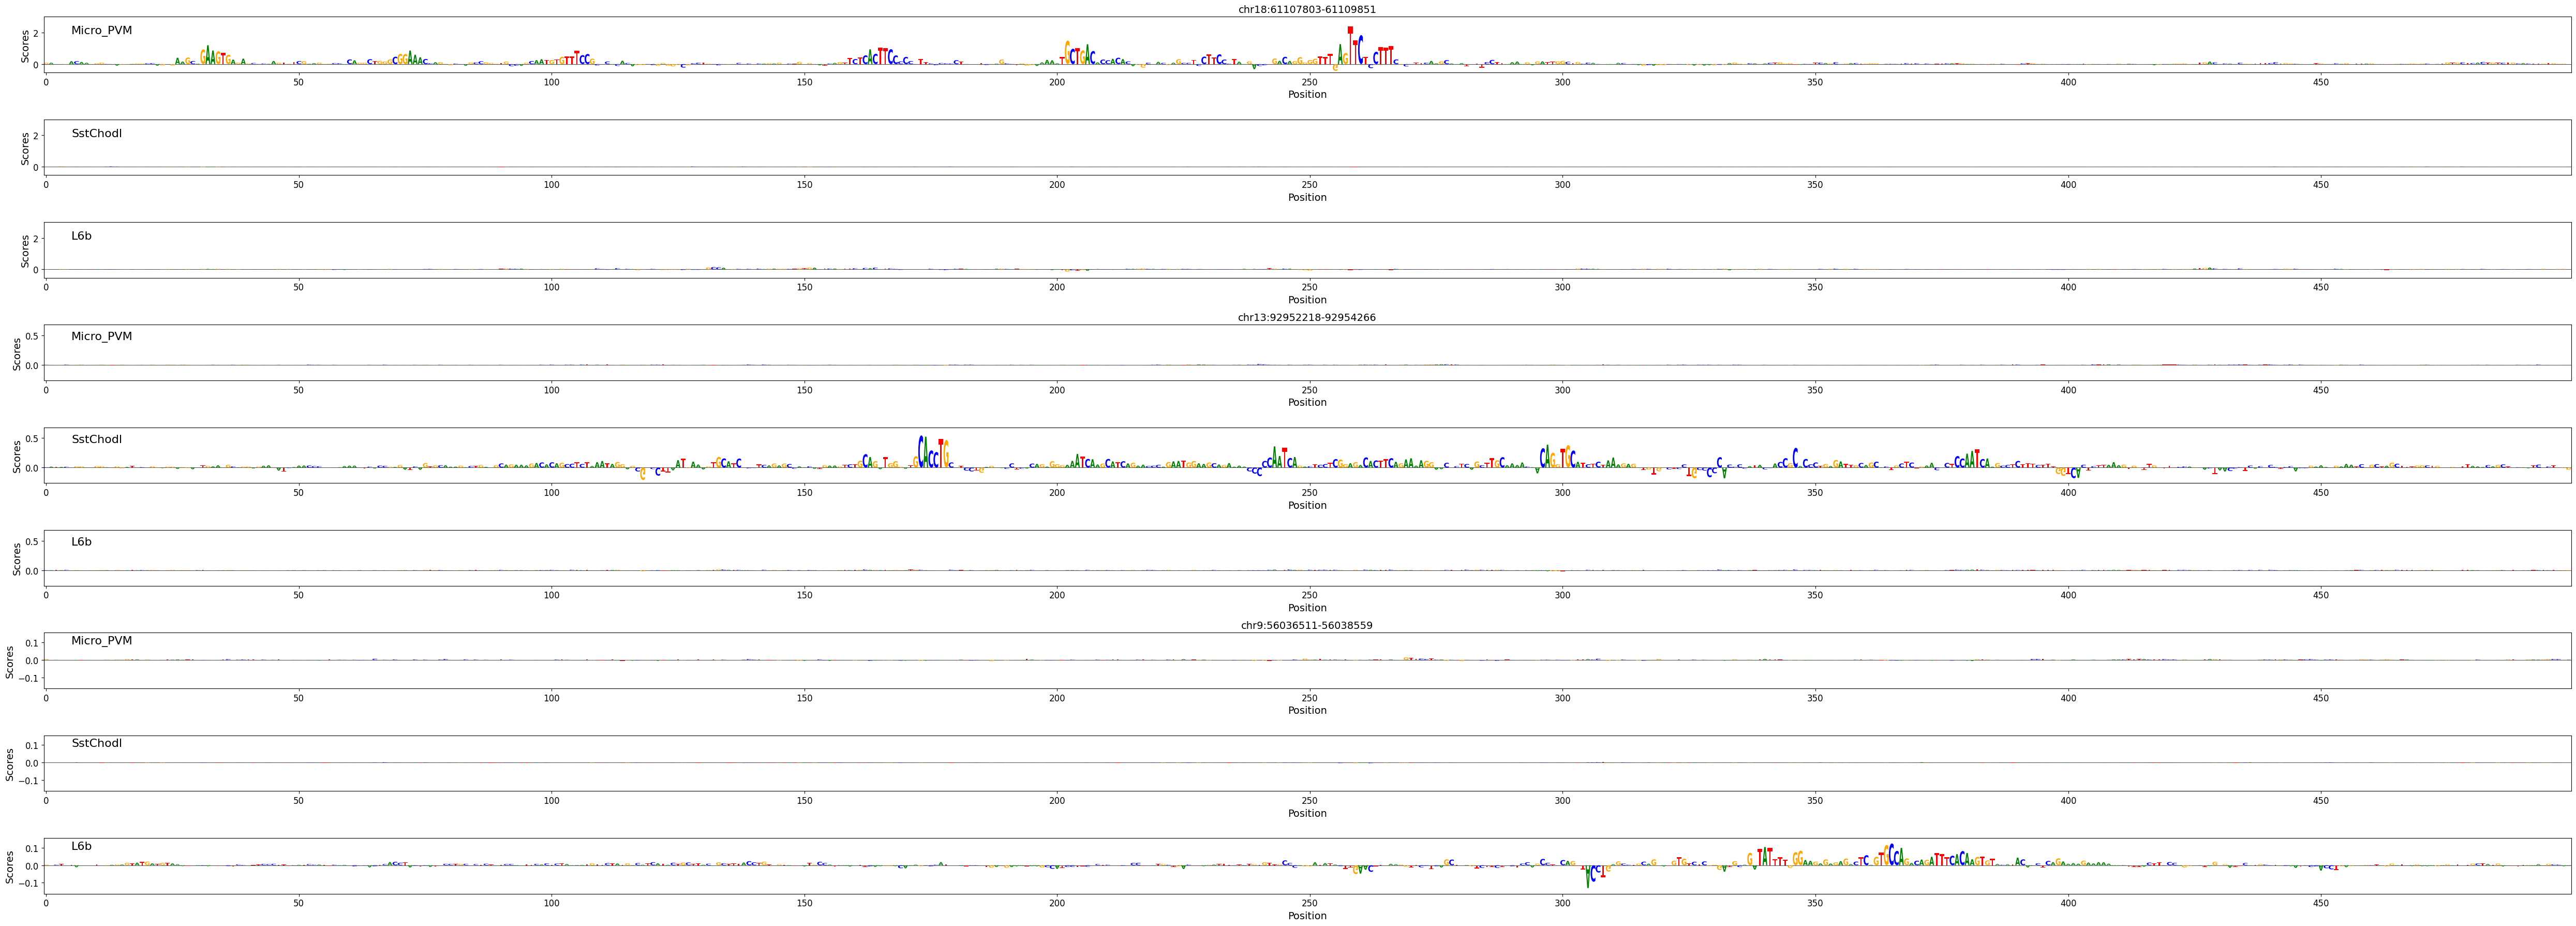

In [49]:
# Plot attribution scores
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=regions_of_interest,
    class_labels=classes_of_interest,
    zoom_n_bases=500
)